In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Hyper-parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.003

In [5]:
# the dataset has PILImage image of range 0~1.
# transform to tensors of normalizes range -1~1.
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                          shuffle=False)

classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

KeyboardInterrupt: 

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

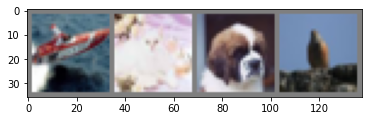

In [6]:
# showing random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [7]:
# implement conv net
# input -> conv+relu -> pooling -> conv+relu -> pooling -> ... -> 
# flatten -> fully conected -> softmax
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # channel = 3, output channel size = 6, kernel size = 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # kernel size = 2, stride = 2 
        self.pool = nn.MaxPool2d(2, 2)
        # input channel size = last output channel size (6), output = 16, kernel size = 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # fully conected layer
        # input size of first linear layer = 16*5*5
        self.fc1 = nn.Linear(16*5*5, 120)
        # input = last output
        self.fc2 = nn.Linear(120, 84)
        # input = last output, output = 10 -> 10 classes
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # first conv and pool layer
        x = self.pool(F.relu(self.conv1(x)))
        # second conv and pool layer
        x = self.pool(F.relu(self.conv2(x)))
        # flatten
        x = x.view(-1, 16*5*5)
        # fully conected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # softmax already included in coss entropy loss
        x = self.fc3(x)
        
        return x

        

In [8]:
model = ConvNet().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')   
            
print('Finished Training')

Epoch [1/4], Step [2000/12500], Loss: 2.3972
Epoch [1/4], Step [4000/12500], Loss: 2.4014
Epoch [1/4], Step [6000/12500], Loss: 1.7044
Epoch [1/4], Step [8000/12500], Loss: 2.4818
Epoch [1/4], Step [10000/12500], Loss: 1.1051
Epoch [1/4], Step [12000/12500], Loss: 0.8676
Epoch [2/4], Step [2000/12500], Loss: 1.9959
Epoch [2/4], Step [4000/12500], Loss: 0.4093
Epoch [2/4], Step [6000/12500], Loss: 2.3919
Epoch [2/4], Step [8000/12500], Loss: 0.5148
Epoch [2/4], Step [10000/12500], Loss: 0.8922
Epoch [2/4], Step [12000/12500], Loss: 0.9116
Epoch [3/4], Step [2000/12500], Loss: 2.8853
Epoch [3/4], Step [4000/12500], Loss: 0.8030
Epoch [3/4], Step [6000/12500], Loss: 0.7143
Epoch [3/4], Step [8000/12500], Loss: 1.2858
Epoch [3/4], Step [10000/12500], Loss: 0.7909
Epoch [3/4], Step [12000/12500], Loss: 0.7825
Epoch [4/4], Step [2000/12500], Loss: 0.9435
Epoch [4/4], Step [4000/12500], Loss: 1.4420
Epoch [4/4], Step [6000/12500], Loss: 0.8837
Epoch [4/4], Step [8000/12500], Loss: 1.0861
Epoc

In [11]:
# evaluate model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network: {acc}%')

Accuracy of the network: 58.97%
